This notebook runs over some considerations in setting up a good calculation including making sure that the structure input is correct (ie. correct units and atomic vibration amplitudes) and that the simulation grid is appropriately sized (in Angstroms) and adequately sampled (in Angstroms per pixel).

First we need mind the units of the atomic coordinates and their vibrational amplitude. The cell belows shows correct and incorrect 

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


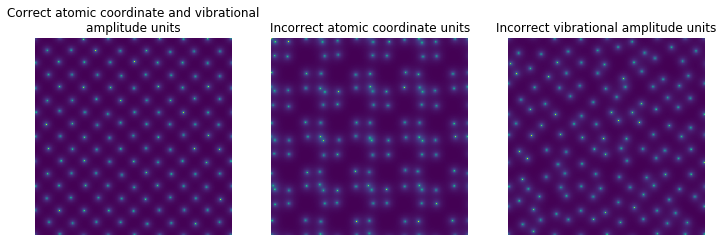

In [15]:
import pyms
%pylab
%matplotlib inline
tiling = [4,4]
gridshape= [512,512]

fig,ax  = plt.subplots(ncols=3,figsize=(12,4))
for a in ax:
    a.set_axis_off()

# The example structure is Si 100, and the input file has atomic coordinates
# in cartesian units (the default is fractional units) and atomic vibrational
# amplitudes in units of root mean square vibration in Angstroms (the
# default is mean square vibration). The structure looks a little off
# and the calculations will be very wrong if this step is not done properly:
    
    
structure = pyms.structure.fromfile("Structures/Si100.xyz",temperature_factor_units='urms',atomic_coordinates='cartesian')
ax[0].imshow(structure.make_potential(gridshape,tiling=tiling).cpu().numpy()[0])
ax[0].set_title('Correct atomic coordinate and vibrational\namplitude units')
structure = pyms.structure.fromfile("Structures/Si100.xyz",atomic_coordinates='fractional',temperature_factor_units='urms')
ax[1].set_title('Incorrect atomic coordinate units')
ax[1].imshow(structure.make_potential(gridshape,tiling=tiling).cpu().numpy()[0])
ax[2].set_title('Incorrect vibrational amplitude units')
structure = pyms.structure.fromfile("Structures/Si100.xyz",temperature_factor_units='ums',atomic_coordinates='cartesian')
ax[2].imshow(structure.make_potential(gridshape,tiling=tiling).cpu().numpy()[0])

We now cover pixel grid selection with the example of the SrTiO$_3$-CeO$_2$ interface. The first thing to do is to load our specimen into memory and work out the subslicing, we use the function  `generate_slicing_figure` to help us here. We want the red dashed lines to ideally sit just ontop of the atoms in the column. Aim for slices to be spaced around 2 Å.

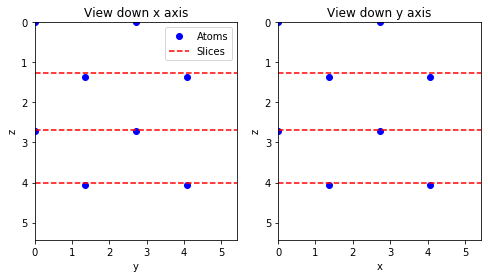

In [16]:
import pyms
import numpy as np
%matplotlib inline
structure = pyms.structure.fromfile("Structures/Si100.xyz",temperature_factor_units='urms',atomic_coordinates='cartesian')

# Even slicing: some minor errors will exhibit in the calculation
# slice_size = 2/structure.unitcell[2]
nslices = int(np.ceil(structure.unitcell[2]/2))
slices = np.linspace(1.0/nslices,1.0,nslices)
slices[-1]=1.0
# bespoke slicing: minimal error
slices = np.asarray([1.26,2.7,4.00]) /structure.unitcell[2]

_ = structure.generate_slicing_figure(slices,show=False)


Now we need to choose the appropriate tiling and grid sampling for the simulation.

A multislice calculation assumes periodic boundary conditions. To avoid artefacts associated with this the pixel grid must be chosen to have sufficient size so that the probe does not artificially interfere with itself through the periodic boundary (wrap around error). The grid sampling must also be sufficient that electrons scattered to high angles are not scattered beyond the band-width limit of the array.

The function `generate_probe_spread_plot` plot helps identify whenever these two events are happening. If the probe intensity drops below 0.95 (as a fraction of initial intensity) then the grid is not sampled finely enough, the pixel size of the array (gridshape) needs to increased for finer sampling of the specimen potential. If the probe spread exceeds 0.2 (as a fraction of the array) then too much of the probe is spreading to the edges of the array, the real space size of the array (usually controlled by the tiling of the unit cell) needs to be increased.

(279,) (279,)


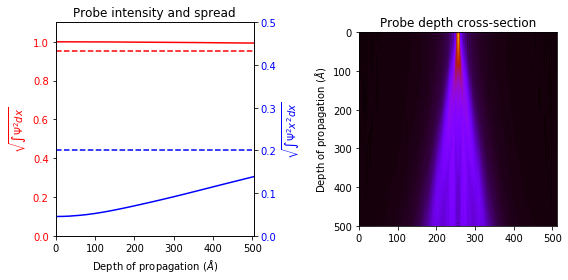

In [32]:

import torch

# Inadequate pixel sampling - probe intensity will drop too much
gridshape = [128, 128]
tiling = [6, 6]

# Adequate real space sampling - probe will spread outside of simulation array
gridshape = [512, 512]
tiling = [4, 4]

# Adequate pixel sampling
gridshape = [512, 512]
tiling = [8, 8]

# The above results might change with these parameters, have a play around
# Probe accelerating voltage
eV = 3e5
app = 20
probe_posn = [0.5, 0.0]
df = 0
thickness = 500

_ = pyms.generate_probe_spread_plot(
    gridshape,
    structure,
    eV,
    app,
    thickness,
    subslices=slices,
    tiling=tiling,
    showcrossection=True,
    probe_posn=probe_posn,
    df = df,
    device=torch.device('cuda')
)